### This *.ipynb find solve problem or task 1:
```
1. XY_train.csv in folder ‘’Task 1’’ contains a dataset of Views against 6 input variables.

==================================================================
a. Select and train a model to predict the views for a given video, given the features provided.
b. Explain your choice of model and why it is suitable for this problem
c. Comment on your model’s performance as well as the significance of each feature.
d.	Provide predictions for views of videos within X_test.csv, as well as an estimation of your out-of-sample performance.

```

In [50]:
import warnings
# suppress all warnings
warnings.filterwarnings("ignore")

In [52]:
## Let me import necessary module,library etc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import seaborn as sns


#sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import root_mean_squared_error as RMSE, mean_absolute_error as MAE, r2_score as R2, mean_squared_error  as MSE 

from sklearn.ensemble import RandomForestRegressor as RF 
from sklearn.linear_model import LinearRegression as LR
from sklearn.tree import DecisionTreeRegressor as DT 
from sklearn.neighbors import KNeighborsRegressor as KNN  
from sklearn.neural_network import MLPRegressor as MLP 
from sklearn.ensemble import GradientBoostingRegressor as GBR 
from sklearn.ensemble import StackingRegressor as STR 
from sklearn.svm import LinearSVR, SVR 
from sklearn.ensemble import ExtraTreesRegressor as ETR 
from xgboost import XGBRegressor as XGB 


from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectFromModel 


#model serialization if required(needed)
import pickle
import joblib

##from Numpy
from numpy import percentile


In [53]:
### Function that returns columns with missing data if any
def return_column_with_missing_dataset(df):
    assert isinstance(df,pd.DataFrame), "df needs to be dataframe"
    column_to_return = df.isin([np.nan,np.inf, -np.inf]).any(axis = 0)
    return df.columns[column_to_return]

### Load the training and test data

In [62]:
try:
    df_train_o = pd.read_csv("XY_train.csv")
    df_test_o = pd.read_csv("X_test.csv")
    print("\n\nThis is top 5 rows of the training data")
    display(df_train_o.head())
    print("\n\nThis is top 5 rows of the test data")
    display(df_test_o.head())

except FileNotFoundError:
    print("Error: One or both of the CSV file were not found.")
    df_train_o = None
    df_test_o  = None

except pd.errors.ParserError:
    print("Error: There was an issue parsing the CSV file(s). The file format may be incorrect.")
    df_train_o = None
    df_test_o  = None 

except Exception as e:
    print(f"An unexpected error occured: {e}")
    df_train_o = None
    df_test_o  = None 



This is top 5 rows of the training data


,Shares,Comments added,Likes (vs. dislikes) (%),Average view duration,Views,Subscribers,Impressions click-through rate (%)
0,2035.0,1578.0,97.95,0:09:32,4319500.0,3574.0,4.66
1,1070.0,1878.0,97.92,0:10:38,2522030.0,4845.0,5.14
2,1375.0,4314.0,97.54,0:09:31,3564849.0,8505.0,7.00
3,420.0,502.0,98.34,0:06:06,1148850.0,513.0,7.27
4,982.0,977.0,97.43,0:07:32,1559413.0,3865.0,5.08




This is top 5 rows of the test data


,Shares,Comments added,Likes (vs. dislikes) (%),Average view duration,Subscribers,Impressions click-through rate (%),Views prediction
0,27558,3243,95.66,00:11:10,28895,4.84,NaN
1,575,942,98.10,00:10:59,879,5.99,NaN
2,5362,1903,95.28,00:06:27,10362,5.98,NaN
3,1231,465,93.65,00:10:26,3119,5.35,NaN
4,4115,2126,97.16,00:13:42,10311,3.55,NaN


In [63]:

print("\n\nThis is bottom 5 rows of the training data")
display(df_train_o.tail())
print("\n\nThis is bottom 5 rows of the test data")
display(df_test_o.tail())



This is bottom 5 rows of the training data


,Shares,Comments added,Likes (vs. dislikes) (%),Average view duration,Views,Subscribers,Impressions click-through rate (%)
490,NaN,NaN,NaN,NaN,NaN,NaN,NaN
491,NaN,NaN,NaN,NaN,NaN,NaN,NaN
492,NaN,NaN,NaN,NaN,NaN,NaN,NaN
493,NaN,NaN,NaN,NaN,NaN,NaN,NaN
494,NaN,NaN,NaN,NaN,NaN,NaN,NaN




This is bottom 5 rows of the test data


,Shares,Comments added,Likes (vs. dislikes) (%),Average view duration,Subscribers,Impressions click-through rate (%),Views prediction
66,587,1895,98.66,00:07:08,4277,8.73,NaN
67,922,824,98.28,00:07:37,2621,4.74,NaN
68,1141,2196,97.93,00:12:46,5965,5.10,NaN
69,1292,576,98.39,00:09:58,939,5.76,NaN
70,1427,3026,97.50,00:09:42,20726,5.15,NaN


## Data Exploration Analysis (EDA)

In [64]:
## to display the shape of the dataframe
print("Shape of the df_train", df_train_o.shape)

# to examine the data types and missing vaues 
display(df_train_o.info())

# Let get the summary of statisticas for numerical columns 
display(df_train_o.describe())

Shape of the df_train (495, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Shares                              429 non-null    float64
 1   Comments added                      429 non-null    float64
 2   Likes (vs. dislikes) (%)            429 non-null    float64
 3   Average view duration               429 non-null    object 
 4   Views                               429 non-null    float64
 5   Subscribers                         429 non-null    float64
 6   Impressions click-through rate (%)  429 non-null    float64
dtypes: float64(6), object(1)
memory usage: 27.2+ KB


None

,Shares,Comments added,Likes (vs. dislikes) (%),Views,Subscribers,Impressions click-through rate (%)
count,429.000000,429.000000,429.000000,4.290000e+02,429.000000,429.000000
mean,2972.510490,1814.564103,97.701166,3.463973e+06,8346.899767,5.590396
std,7274.326258,1622.438045,0.907702,3.222874e+06,12810.100013,1.112541
min,203.000000,187.000000,91.330000,1.033484e+06,341.000000,2.620000
25%,900.000000,755.000000,97.340000,1.563399e+06,2117.000000,4.870000
50%,1570.000000,1221.000000,97.880000,2.357541e+06,4216.000000,5.460000
75%,2763.000000,2336.000000,98.280000,3.982387e+06,8505.000000,6.230000
max,106414.000000,9109.000000,99.120000,2.803736e+07,120906.000000,10.420000


It is obvious there is are missing value at the bottom rows and the values of some fateures are very largge  and some are small. Thus it rquired to scale the values of these features. In addition columns:  Average view duration is an object and must be converted to seconds in uniquiz format

In [65]:
df_train = df_train_o.dropna(axis=0)
df_train.info()

df_test = df_test_o.drop('Views prediction', axis = 1)
df_test = df_test.dropna(axis=0)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 429 entries, 0 to 428
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Shares                              429 non-null    float64
 1   Comments added                      429 non-null    float64
 2   Likes (vs. dislikes) (%)            429 non-null    float64
 3   Average view duration               429 non-null    object 
 4   Views                               429 non-null    float64
 5   Subscribers                         429 non-null    float64
 6   Impressions click-through rate (%)  429 non-null    float64
dtypes: float64(6), object(1)
memory usage: 26.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 6 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Shares                    

In [66]:
## to display the shape of the dataframe
print("Shape of the df_test", df_test.shape)

# to examine the data types and missing vaues 
display(df_test.info())

# Let get the summary of statisticas for numerical columns 
display(df_test.describe())

Shape of the df_test (71, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 6 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Shares                              71 non-null     int64  
 1   Comments added                      71 non-null     int64  
 2   Likes (vs. dislikes) (%)            71 non-null     float64
 3   Average view duration               71 non-null     object 
 4   Subscribers                         71 non-null     int64  
 5   Impressions click-through rate (%)  71 non-null     float64
dtypes: float64(2), int64(3), object(1)
memory usage: 3.5+ KB


None

,Shares,Comments added,Likes (vs. dislikes) (%),Subscribers,Impressions click-through rate (%)
count,71.000000,71.000000,71.000000,71.000000,71.000000
mean,3040.577465,2193.422535,97.560986,9114.549296,5.618873
std,4061.666261,2448.282749,1.249443,10849.154230,1.702244
min,285.000000,426.000000,90.930000,355.000000,3.550000
25%,1035.500000,844.500000,97.235000,2172.000000,4.900000
50%,1437.000000,1524.000000,97.910000,5965.000000,5.410000
75%,3491.500000,2525.000000,98.285000,10368.000000,5.970000
max,27558.000000,15923.000000,98.850000,64992.000000,17.070000


In [67]:
def to_seconds(time_str):
    '''
       Convert time string in H:M:S format to seconds

    '''
    if pd.isna(time_str) or not isinstance(time_str, str):
        return np.nan

    try:
        if ':' in time_str:
            parts = time_str.split(":")
            if len(parts)  == 3:
                h,m,s  =  map(int,parts)
                return h * 3600 + m * 60 + s 
            elif len(parts)  == 2:
                m, s  = map(int, parts)
                return m * 60 + s 
        return float(time_str)
    except ValueError:
        return np.nan
    
df_train['Average view duration'] = df_train['Average view duration'].apply(to_seconds)
df_test['Average view duration']  = df_test['Average view duration'].apply(to_seconds)

print("\n\nThis is top 5 rows of the training data")
display(df_train.head())
print("\n\nThis is top 5 rows of the test data")
display(df_test.head())




This is top 5 rows of the training data


,Shares,Comments added,Likes (vs. dislikes) (%),Average view duration,Views,Subscribers,Impressions click-through rate (%)
0,2035.0,1578.0,97.95,572,4319500.0,3574.0,4.66
1,1070.0,1878.0,97.92,638,2522030.0,4845.0,5.14
2,1375.0,4314.0,97.54,571,3564849.0,8505.0,7.00
3,420.0,502.0,98.34,366,1148850.0,513.0,7.27
4,982.0,977.0,97.43,452,1559413.0,3865.0,5.08




This is top 5 rows of the test data


,Shares,Comments added,Likes (vs. dislikes) (%),Average view duration,Subscribers,Impressions click-through rate (%)
0,27558,3243,95.66,670,28895,4.84
1,575,942,98.10,659,879,5.99
2,5362,1903,95.28,387,10362,5.98
3,1231,465,93.65,626,3119,5.35
4,4115,2126,97.16,822,10311,3.55


In [68]:
# to examine the data types and missing vaues 
display(df_train.info())

# Let get the summary of statisticas for numerical columns 
display(df_train.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 429 entries, 0 to 428
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Shares                              429 non-null    float64
 1   Comments added                      429 non-null    float64
 2   Likes (vs. dislikes) (%)            429 non-null    float64
 3   Average view duration               429 non-null    int64  
 4   Views                               429 non-null    float64
 5   Subscribers                         429 non-null    float64
 6   Impressions click-through rate (%)  429 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 26.8 KB


None

,Shares,Comments added,Likes (vs. dislikes) (%),Average view duration,Views,Subscribers,Impressions click-through rate (%)
count,429.000000,429.000000,429.000000,429.000000,4.290000e+02,429.000000,429.000000
mean,2972.510490,1814.564103,97.701166,549.104895,3.463973e+06,8346.899767,5.590396
std,7274.326258,1622.438045,0.907702,142.429080,3.222874e+06,12810.100013,1.112541
min,203.000000,187.000000,91.330000,218.000000,1.033484e+06,341.000000,2.620000
25%,900.000000,755.000000,97.340000,443.000000,1.563399e+06,2117.000000,4.870000
50%,1570.000000,1221.000000,97.880000,553.000000,2.357541e+06,4216.000000,5.460000
75%,2763.000000,2336.000000,98.280000,642.000000,3.982387e+06,8505.000000,6.230000
max,106414.000000,9109.000000,99.120000,1088.000000,2.803736e+07,120906.000000,10.420000


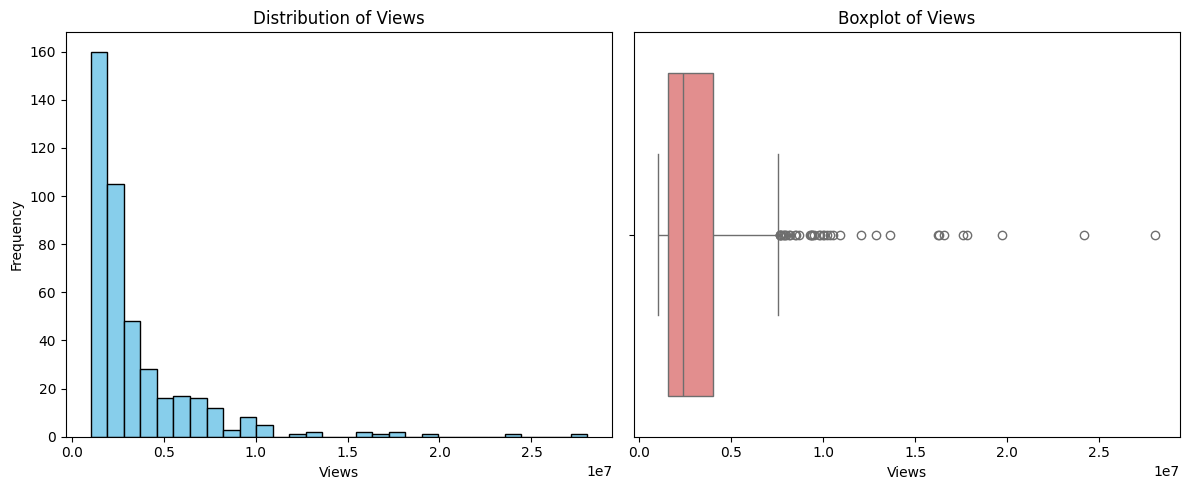

In [69]:
## Analyzes the distribution of the target variable " Views"
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.hist(df_train['Views'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Views')
plt.xlabel('Views')
plt.ylabel('Frequency')
''' 
#plt.subplot(1,2,2)
plt.boxplot(df_train['Views'], vert=False, patch_artist=True,
            boxprops=dict(facecolor='lightcoral'),capprops=dict(color='black'),
            whiskerprops=dict(color ='black'),
            flierprops=dict(markeredgecolor='black', marker='o'))
plt.title("Boxplot of Views")
plt.xlabel('Views')
#plt.tight_layout()
plt.show()
'''


plt.subplot(1,2,2)
sns.boxplot(x=df_train['Views'], color='lightcoral')
plt.title("Boxplot of Views")
plt.xlabel('Views')
plt.tight_layout()
plt.show()



##### Here wanted to analyze each feature (excluding views) by generating histograms, boxplots, descriptive statistics, and examining their employing scater plots and coreelation analysis

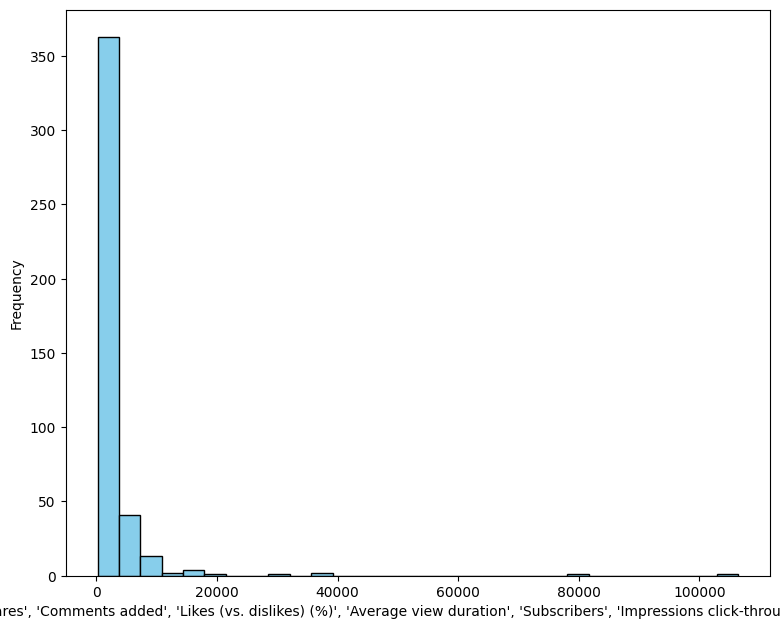

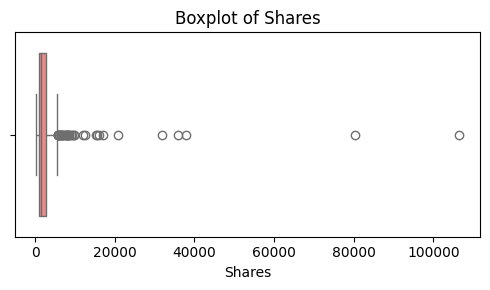

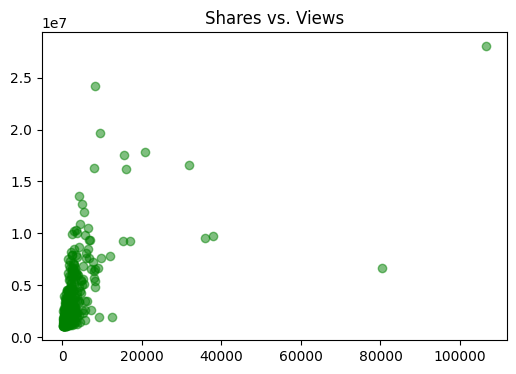

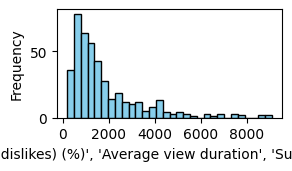

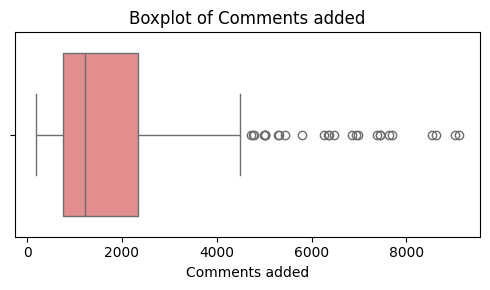

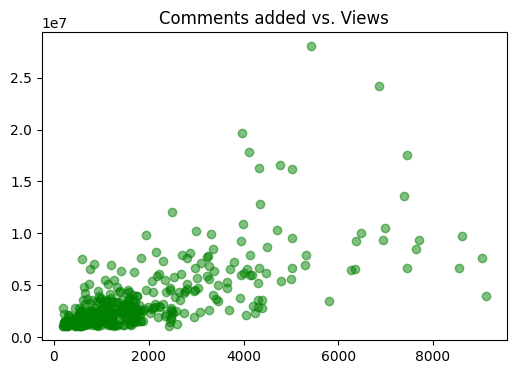

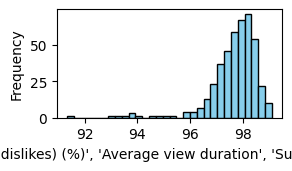

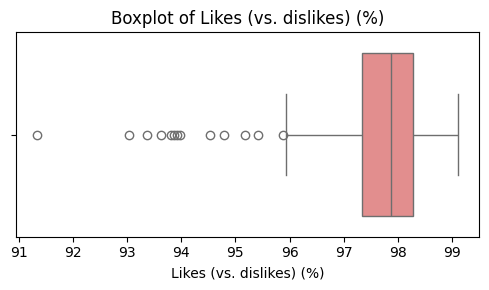

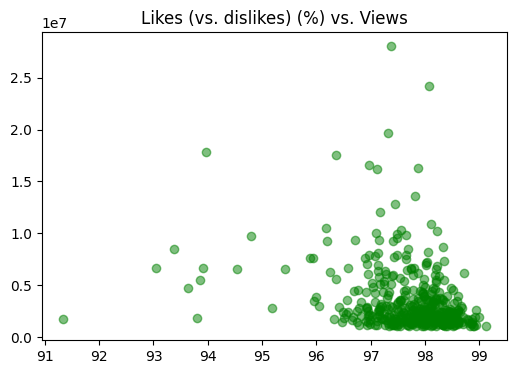

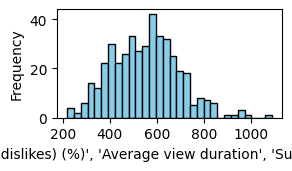

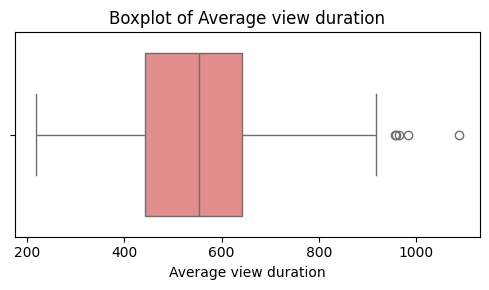

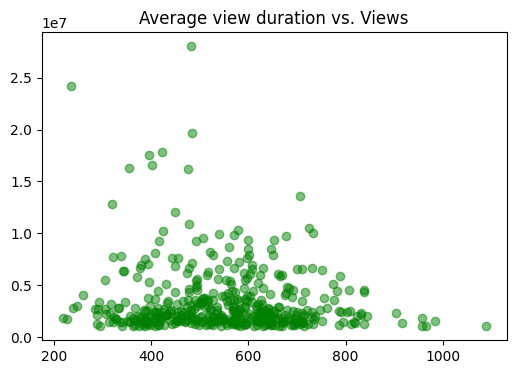

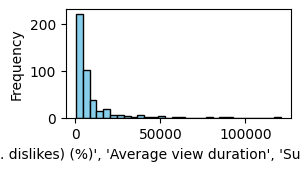

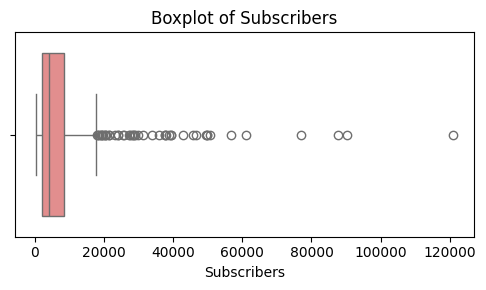

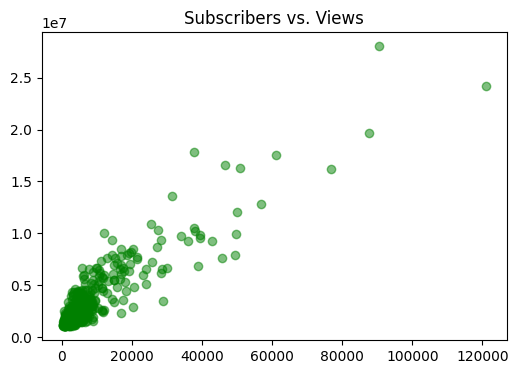

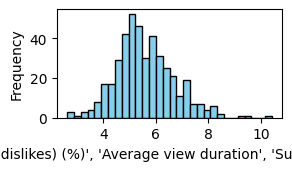

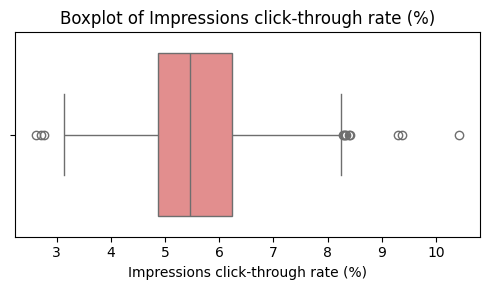

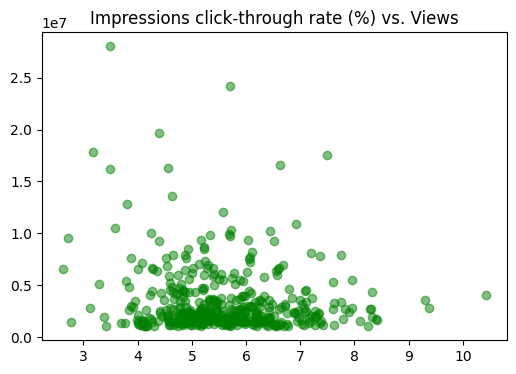

In [70]:
features_columns =  ['Shares',"Comments added", "Likes (vs. dislikes) (%)", "Average view duration"
                     , "Subscribers", "Impressions click-through rate (%)"]

plt.figure(figsize=(20, 25))

for i, feature in enumerate(features_columns):
    plt.subplot(3, 2, i+1)
    plt.hist(df_train[feature], bins=30, color='skyblue', edgecolor='black')
    plt.xlabel(features_columns)
    plt.ylabel('Frequency')

    plt.figure(figsize=(5,3))
    sns.boxplot(x=df_train[feature], color='lightcoral')
    plt.title(f"Boxplot of {feature}")
    plt.xlabel(feature)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.scatter(df_train[feature], df_train['Views'], alpha = 0.5, color='green')
    plt.title(f'{feature} vs. Views')
    plt.show()


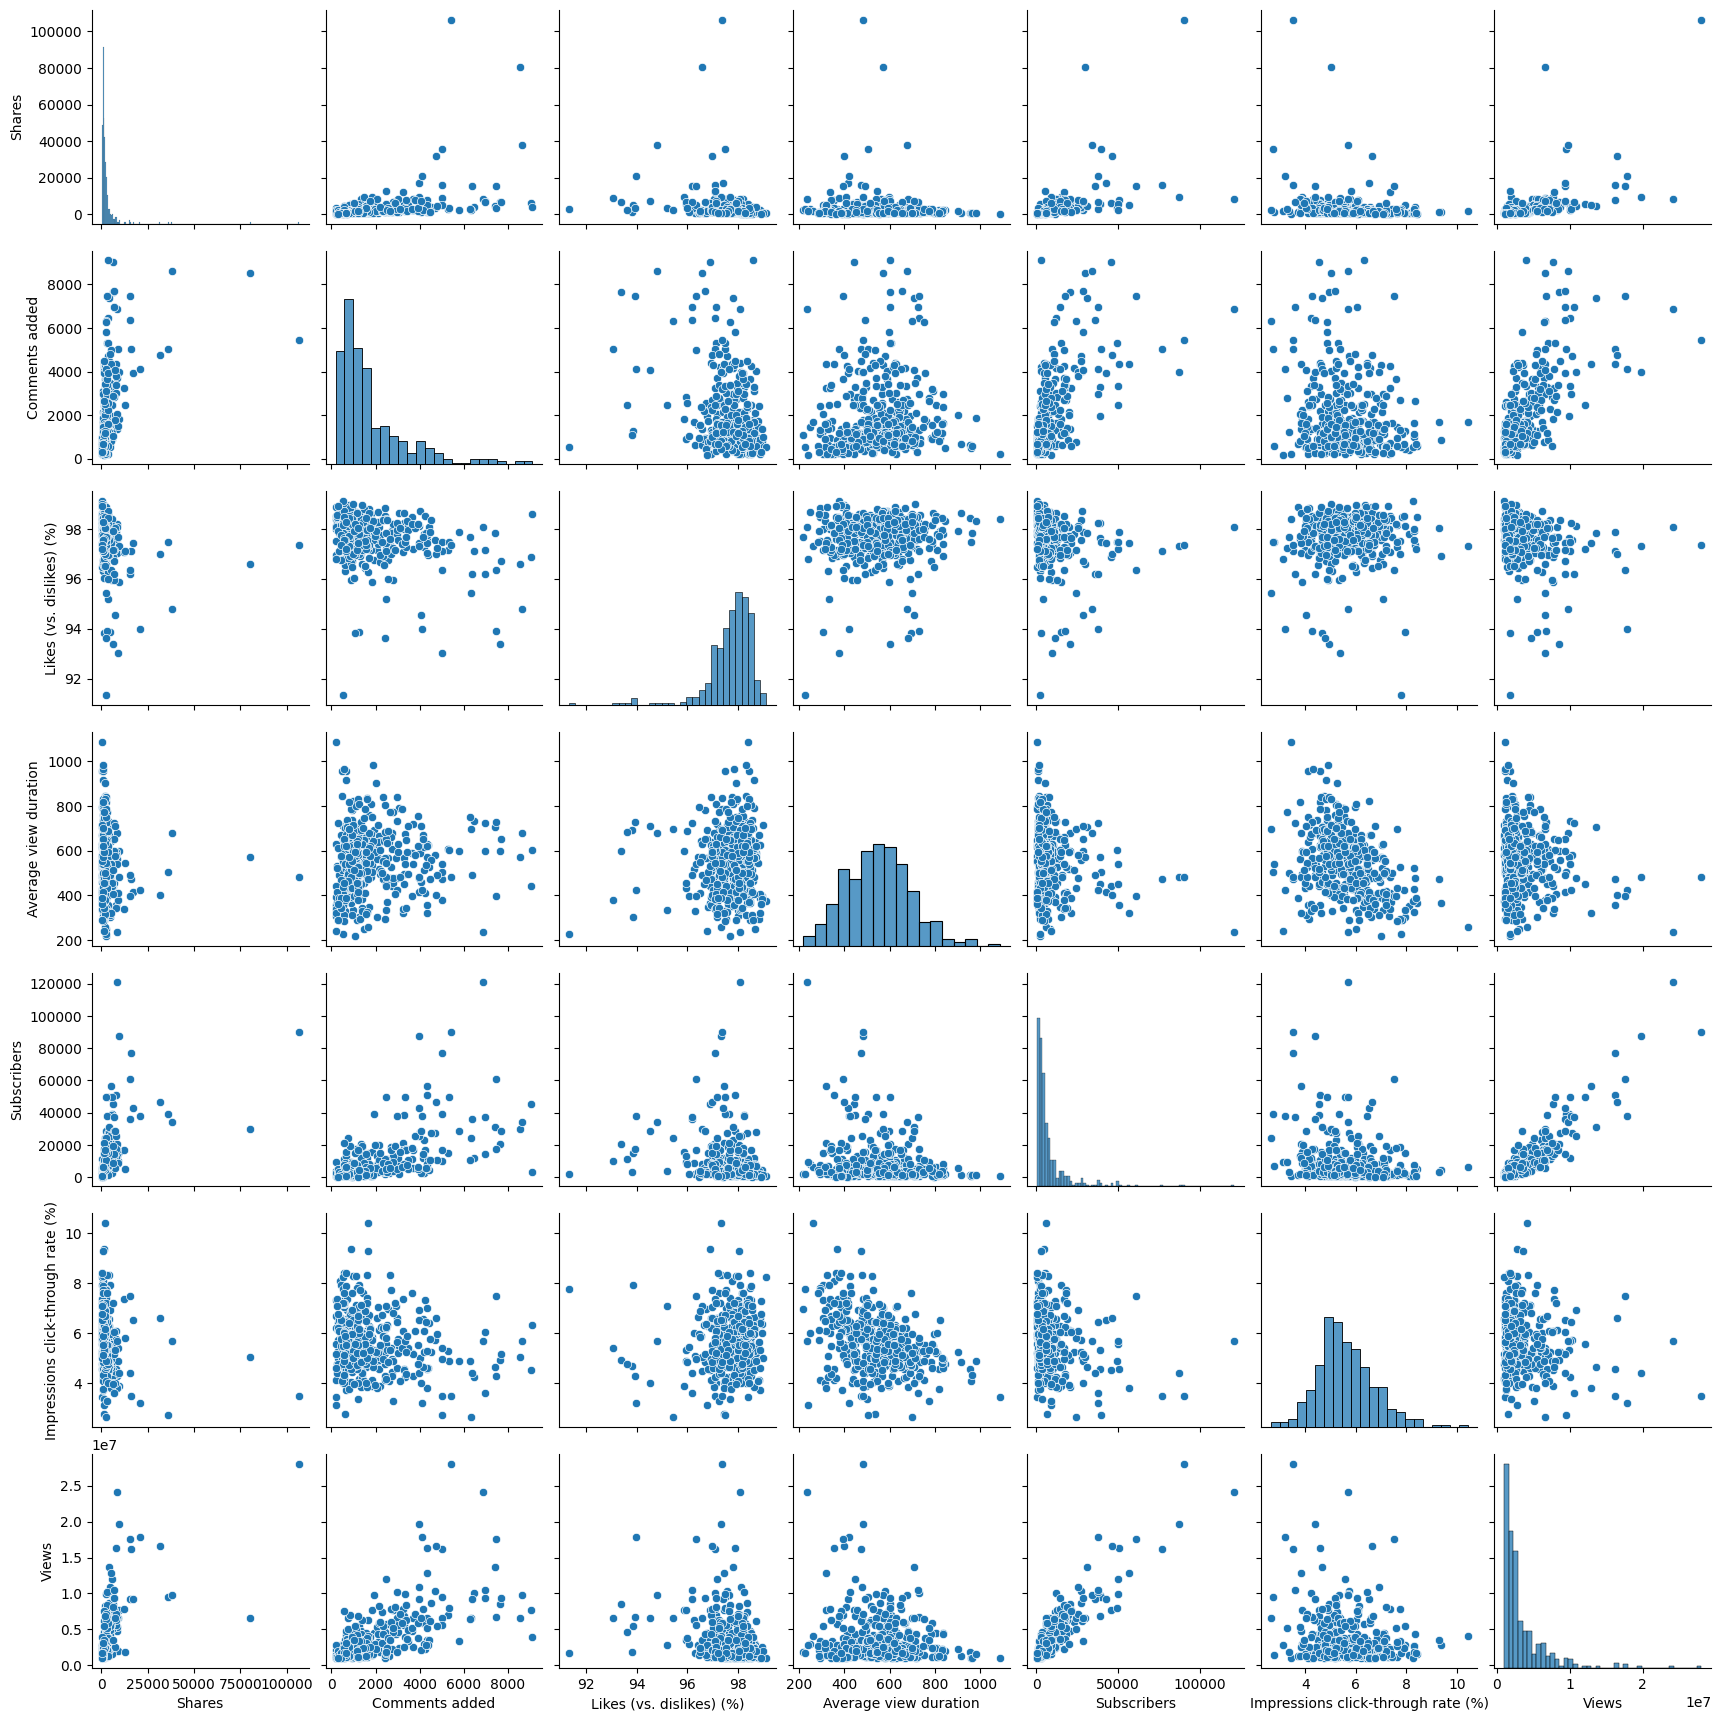

In [71]:
sns.pairplot(df_train[features_columns + ['Views']])  #for all data
plt.show()

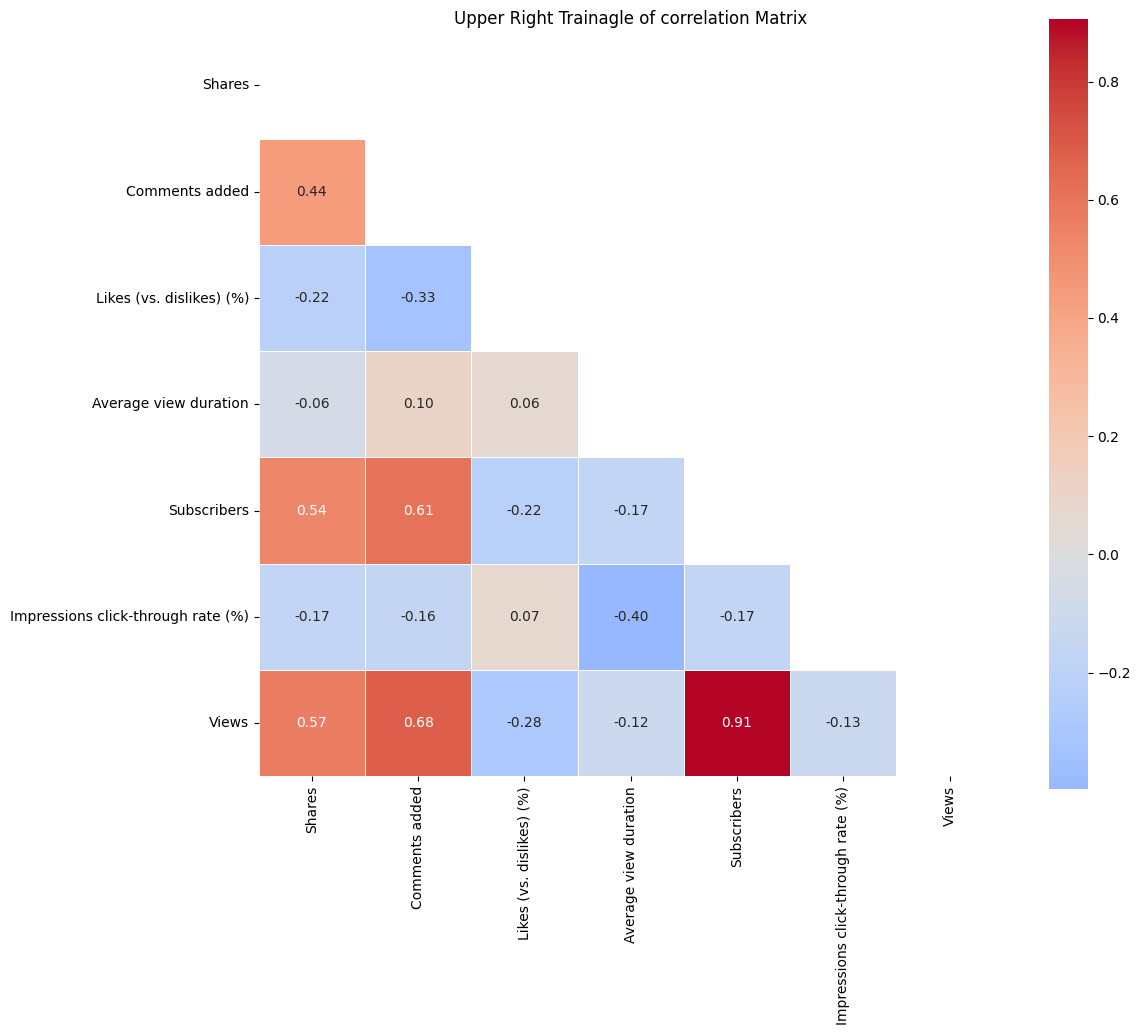

In [72]:
# let eme get correlation matrix. Look to see collinearity
columns_names =  features_columns + ['Views']
corr_matrix = df_train[columns_names].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix,mask=mask,cmap="coolwarm", annot=True,center=0, square=True, linewidth=.5, fmt = '.2f')
plt.title("Upper Right Trainagle of correlation Matrix")
plt.show()

Subscribers                         Comments added              0.614330
                                    Shares                      0.535619
Comments added                      Shares                      0.438593
Impressions click-through rate (%)  Average view duration       0.397481
Likes (vs. dislikes) (%)            Comments added              0.325950
Subscribers                         Likes (vs. dislikes) (%)    0.223176
Likes (vs. dislikes) (%)            Shares                      0.218116
Impressions click-through rate (%)  Subscribers                 0.168358
Subscribers                         Average view duration       0.167363
Impressions click-through rate (%)  Shares                      0.166992
                                    Comments added              0.160692
Average view duration               Comments added              0.102352
Impressions click-through rate (%)  Likes (vs. dislikes) (%)    0.069430
Average view duration               Likes (vs. disl

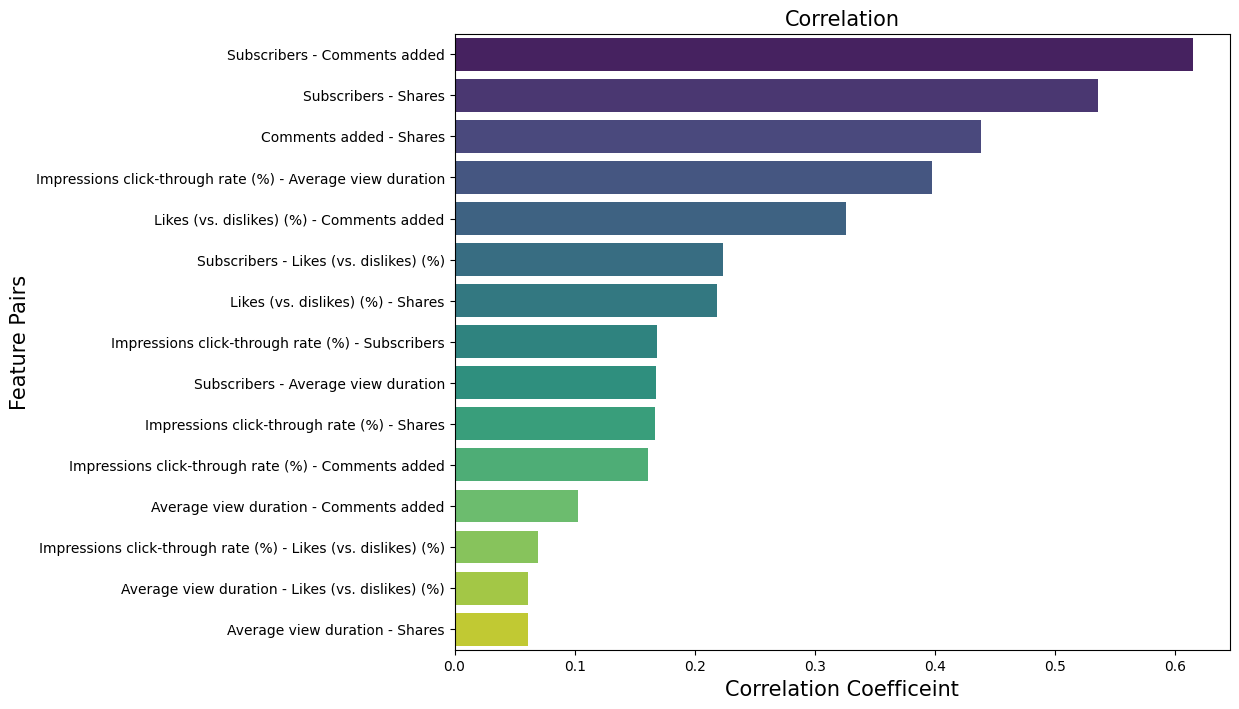

In [73]:
# let eme get correlation matrix. Look to see collinearity without the dependent variables
corr_matrix = df_train[features_columns].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

upper_triangle =  corr_matrix.where(mask)
sorted_corr_matrix = upper_triangle.unstack().dropna().abs().sort_values(ascending=False) 
filtered_corr_values = sorted_corr_matrix[sorted_corr_matrix < 1.0]
print(filtered_corr_values)


filtered_corr_values.index = filtered_corr_values.index.map(' - '.join)
# plot the corr-relation for multicolinerity
plt.figure(figsize=(10,8))
sns.barplot(x=filtered_corr_values.values, y=filtered_corr_values.index, palette="viridis")
plt.title("Correlation", fontsize=15)
plt.xlabel("Correlation Coefficeint", fontsize =15)
plt.ylabel("Feature Pairs", fontsize=15)

#plt.xticks(fontsize=tick_labelsize)
#plt.yticks(fontsize=tick_labelsize)

plt.show()


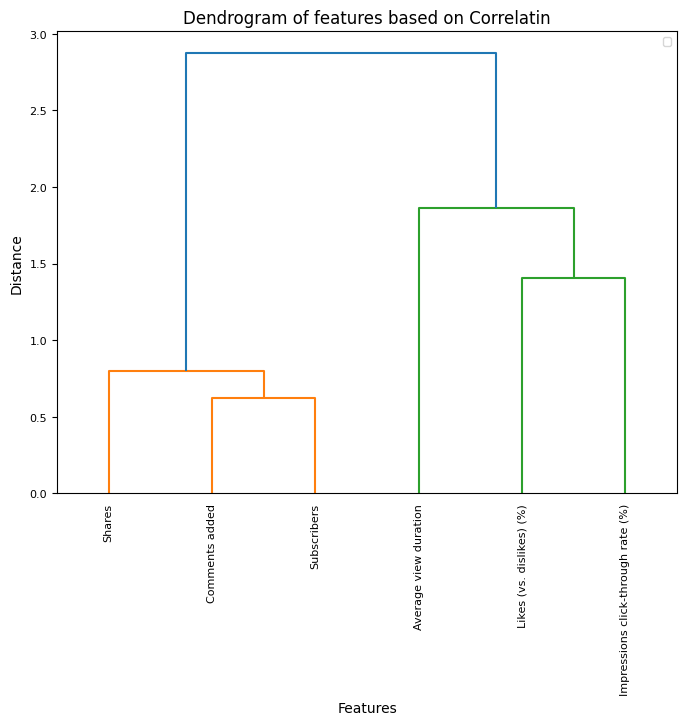

In [74]:
from scipy.cluster.hierarchy import dendrogram, linkage

distance_matrix = 1 - corr_matrix
linkage_matrix = linkage(distance_matrix, method = "ward") # to perform hierachical clustering

#font size values
title_fontsize =  12
label_fontsize =  10
legend_fontsize = 8
tick_labelsize = 8

plt.figure(figsize=(8,6))
dendrogram(linkage_matrix,labels=features_columns, leaf_rotation=90)
plt.title("Dendrogram of features based on Correlatin", fontsize=title_fontsize)
plt.xlabel("Features", fontsize=label_fontsize)
plt.ylabel("Distance", fontsize=label_fontsize)

plt.legend(fontsize=legend_fontsize)
plt.xticks(fontsize=tick_labelsize)
plt.yticks(fontsize=tick_labelsize)
plt.show()



### With all the above correlation, plots etc. It makes sense to use all the feature

In [75]:
df_test.tail()

,Shares,Comments added,Likes (vs. dislikes) (%),Average view duration,Subscribers,Impressions click-through rate (%)
66,587,1895,98.66,428,4277,8.73
67,922,824,98.28,457,2621,4.74
68,1141,2196,97.93,766,5965,5.10
69,1292,576,98.39,598,939,5.76
70,1427,3026,97.50,582,20726,5.15


#### Train the ML models using the traiing data after Scaling

In [76]:
X =  df_train.drop('Views', axis = 1)
y = df_train['Views']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train, X_val)

     Shares  Comments added  Likes (vs. dislikes) (%)  Average view duration  \
66   1111.0          1173.0                     97.98                    474   
132   728.0          1163.0                     98.29                    559   
225  2039.0          2449.0                     98.50                    569   
31   3095.0          2600.0                     96.99                    639   
84    650.0           406.0                     97.78                    353   
..      ...             ...                       ...                    ...   
71   2739.0          2528.0                     97.16                    370   
106   831.0           708.0                     98.24                    732   
270  5013.0           801.0                     97.87                    520   
348  1793.0          2021.0                     97.93                    904   
102  1180.0          2572.0                     96.75                    569   

     Subscribers  Impressions click-thr

### I want to train dummy machine lerning model to have bench mark

In [85]:
from sklearn.dummy import DummyRegressor as DR
scaler = MinMaxScaler() # I can do mixture of the scaler basd on the each feature
#scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(X_train)
Xval_scaled  = scaler.transform(X_val)
Xtest_scaled = scaler.transform(df_test)


## get the result for the dummy model for cmaprasion
Dummy_model =  DR(strategy="median")
Dummy_model.fit(Xtrain_scaled,y_train)
y_train_pred = Dummy_model.predict(Xtrain_scaled)
y_val_pred = Dummy_model.predict(Xval_scaled)

train_r2   = R2(y_train, y_train_pred.round(2))
train_rmse = np.sqrt(MSE(y_train,y_train_pred))
train_mae   = MAE(y_val,y_val_pred)

val_r2   = R2(y_val, y_val_pred)
val_rmse = np.sqrt(MSE(y_val,y_val_pred))
val_mae   = MAE(y_val,y_val_pred)




Dummy_model_result = {
        "R2 Train": train_r2,
        "RMSE Train": train_rmse,
        "MAE Train": train_mae,
        'R2 test': val_r2,
        'RMSE Test': val_rmse,
        'MAE Test': val_mae
    }

#pd.DataFrame(Dummy_model_result, index = 'row')
Dummy_model_result

{'R2 Train': -0.10768718691939827,
 'RMSE Train': np.float64(3203979.9131677486),
 'MAE Train': 2221711.511627907,
 'R2 test': -0.15816617946517963,
 'RMSE Test': np.float64(4100468.83725521),
 'MAE Test': 2221711.511627907}

In [83]:
print(y_val,np.round(y_val_pred,1))

421     1709818.0
75     10357340.0
177     3042146.0
30      1429084.0
360     1239626.0
          ...    
378     2436285.0
57      2289242.0
124     1651522.0
24      1284134.0
17      5519320.0
Name: Views, Length: 86, dtype: float64 [2361472. 2361472. 2361472. 2361472. 2361472. 2361472. 2361472. 2361472.
 2361472. 2361472. 2361472. 2361472. 2361472. 2361472. 2361472. 2361472.
 2361472. 2361472. 2361472. 2361472. 2361472. 2361472. 2361472. 2361472.
 2361472. 2361472. 2361472. 2361472. 2361472. 2361472. 2361472. 2361472.
 2361472. 2361472. 2361472. 2361472. 2361472. 2361472. 2361472. 2361472.
 2361472. 2361472. 2361472. 2361472. 2361472. 2361472. 2361472. 2361472.
 2361472. 2361472. 2361472. 2361472. 2361472. 2361472. 2361472. 2361472.
 2361472. 2361472. 2361472. 2361472. 2361472. 2361472. 2361472. 2361472.
 2361472. 2361472. 2361472. 2361472. 2361472. 2361472. 2361472. 2361472.
 2361472. 2361472. 2361472. 2361472. 2361472. 2361472. 2361472. 2361472.
 2361472. 2361472. 2361472. 2361

In [92]:
### Get the view predictions by Dummy_model
dummy_views_pred = Dummy_model.predict(Xtest_scaled)
dummy_views_pred

array([2361472., 2361472., 2361472., 2361472., 2361472., 2361472.,
       2361472., 2361472., 2361472., 2361472., 2361472., 2361472.,
       2361472., 2361472., 2361472., 2361472., 2361472., 2361472.,
       2361472., 2361472., 2361472., 2361472., 2361472., 2361472.,
       2361472., 2361472., 2361472., 2361472., 2361472., 2361472.,
       2361472., 2361472., 2361472., 2361472., 2361472., 2361472.,
       2361472., 2361472., 2361472., 2361472., 2361472., 2361472.,
       2361472., 2361472., 2361472., 2361472., 2361472., 2361472.,
       2361472., 2361472., 2361472., 2361472., 2361472., 2361472.,
       2361472., 2361472., 2361472., 2361472., 2361472., 2361472.,
       2361472., 2361472., 2361472., 2361472., 2361472., 2361472.,
       2361472., 2361472., 2361472., 2361472., 2361472.])

### Setting up training other models

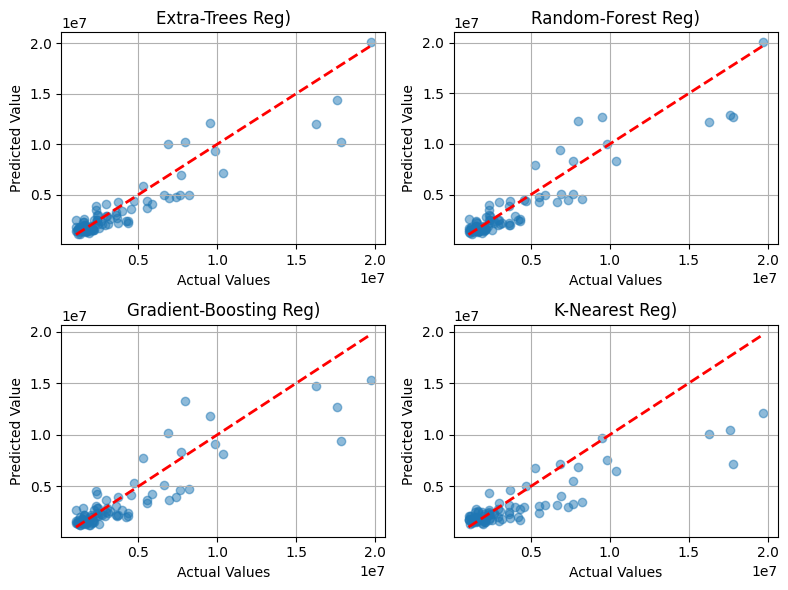

,R2 Train,RMSE Train,MAE Train,R2 val,RMSE val,MAE val
Extra-Trees Reg,1.000000,0.000000e+00,0.000000,0.843682,1.506444e+06,9.664968e+05
Random-Forest Reg,0.958462,6.204477e+05,364894.412828,0.846110,1.494697e+06,9.926997e+05
Gradient-Boosting Reg,0.973457,4.959726e+05,336674.848032,0.781109,1.782635e+06,1.125185e+06
K-Nearest Reg,0.763338,1.480966e+06,874119.806997,0.646432,2.265606e+06,1.328855e+06


In [101]:
models = {
    
    "Extra-Trees Reg": ETR(n_estimators=100,random_state=42),
    "Random-Forest Reg": RF(n_estimators=10,random_state=42),
    'Gradient-Boosting Reg': XGB(n_estimators=10,random_state=42),
    #"Support Vector Reg": SVR(kernel='rbf'),
    "K-Nearest Reg": KNN(n_neighbors=5),
    #"Multi-LP": MLP(hidden_layer_sizes=(32,16), activation="relu", solver='adam', max_iter=1000, random_state=42),
}

def evaluate_model(name, model, X_train,y_train,X_val,y_val,ax):
    
    model.fit(X_train,y_train)
    
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # RMSE, R2 and MAE for the training
    train_r2 = R2(y_train, y_train_pred)
    train_rmse = np.sqrt(MSE(y_train,y_train_pred))
    train_mae   = MAE(y_train,y_train_pred)
    
    # RMSE, R2 and MAE for the test\
    val_r2 = R2(y_val, y_val_pred)
    val_rmse = np.sqrt(MSE(y_val,y_val_pred))
    val_mae   = MAE(y_val,y_val_pred)
    
    # Let show som plot
    ax.scatter(y_val,y_val_pred, alpha =0.5)
    ax.plot([y_val.min(), y_val.max()],[y_val.min(),y_val.max()],'--', color ="red", lw=2)
    ax.set_xlabel("Actual Values")
    ax.set_ylabel("Predicted Value")
    ax.set_title(f'{name})')
    ax.grid(True)
    
    return train_r2,train_rmse, train_mae,val_r2,val_rmse,val_mae


################### training and evaluation start here ###############################
results =  {}
fig, axes =plt.subplots(nrows=2,ncols =2, figsize=(8,6))
axes =  axes.flatten()


for idex, (name,model) in enumerate(models.items()):
    
    
    ### todo to scale the dependent variable
    
    r2_train,rmse_train,mae_train,r2_val,rmse_val,mae_val = evaluate_model(
    name, model, Xtrain_scaled,y_train,Xval_scaled,y_val,axes[idex])
    
    results[name] = {
        "R2 Train": r2_train,
        "RMSE Train": rmse_train,
        "MAE Train": mae_train,
        'R2 val': r2_val,
        'RMSE val': rmse_val,
        'MAE val': mae_val
    }
    
    
plt.tight_layout()
plt.show()

print()
print()
print()


# result in dataframe
results_df =  pd.DataFrame(results).T
results_df


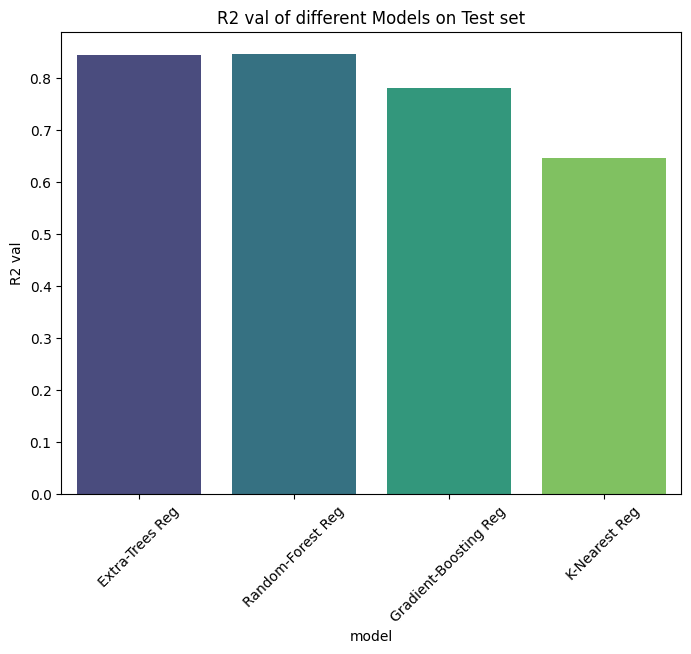

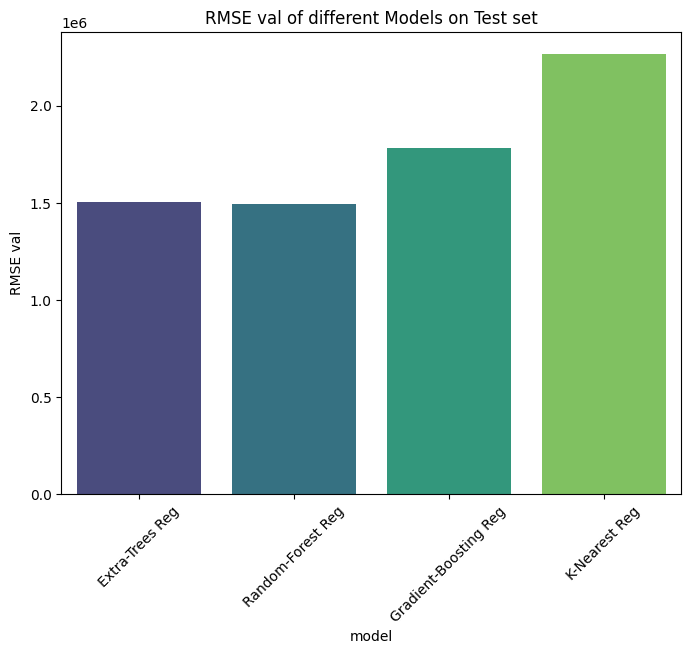

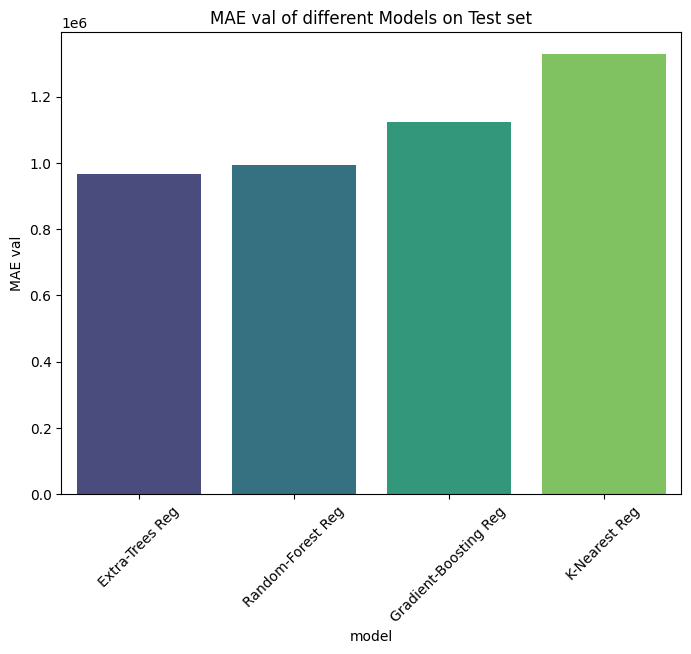

In [102]:
metrics = ['R2 val', 'RMSE val', 'MAE val']

for metric in metrics:
    plt.figure(figsize=(8,6))
    sns.barplot(x=results_df.index, y = results_df[metric], palette='viridis')
    plt.title(f'{metric} of different Models on Test set')
    plt.xlabel('model')
    plt.ylabel(metric)

    plt.xticks(rotation=45)
    plt.show()


print()
print()
print()

#### From the above results the best performing model is Random Forest. Thus, I use the trined random forest to predict the views. I used the test set given

In [103]:
rf = models["Random-Forest Reg"]
Views_Prediction = rf.predict(Xtest_scaled)

In [104]:
# To Replace "View prediction" column with model predictions
df_test["View prediction"] = Views_Prediction

# To Save the updated CSV file
df_test.to_csv("X_test_updated.csv", index=False)

print("Predictions saved successfully!")

Predictions saved successfully!
